In [4]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand
import pickle as rick

alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e
Gam_Z = 2.4952
C_eB = 10 ** -10
C_eW = C_eB
C_eH = 10 ** -10
C_HB = 2 * 10 ** -10
C_HW = 10 ** -10
#Pick C_HD and C_HWB s.t. we can use the SM vev
C_HD = 10 ** -10
C_HWB = C_HD
C_AA = cos ** 2 * C_HB + sin ** 2 * C_HW - sin * cos * C_HWB
C_AZ = 2 * sin * cos * (C_HW - C_HB) - (cos ** 2 - sin ** 2) * C_HWB

def diff_decay2(s, t, ml, C_eB, C_eW, C_AA, C_AZ, C_eH, SW, CW):
    N = 1 / (32 * (2 * np.pi) ** 3  * m_h ** 3)
    u = m_h ** 2 + 2 * ml ** 2 - s - t
    struc_4 = (4 * e ** 2 * (m_h ** 4 + s ** 2)) / (t * u) #1/v^2
    
    f6_AA = (-64 * C_AA * ml ** 2 * m_W ** 2) / (v ** 2 * s * (t - ml ** 2) * (u - ml ** 2)) #1/v^2
    struc_6_AA = f6_AA * (-(t - ml ** 2) ** 3 - (u - ml ** 2)** 3 + (t - ml ** 2) ** 2 * (u - ml ** 2) + (t - ml ** 2) * (u - ml ** 2) * (u - ml ** 2 - 4 * m_h ** 2) + 4 * ml ** 2 * (u + t - 2 * ml ** 2) ** 2)
    f8_AA = (64 * C_AA ** 2 * m_W ** 2 * SW ** 2) / u
    struc_8_AA = f8_AA * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f6_AZ = ((-8 * C_AZ * ml ** 2 * m_W ** 2 * SW ** 2 * (CW ** 2 - 3 * SW ** 2)) / (SW * CW * v ** 2 * (u - ml ** 2) * (t - ml ** 2))) * ((m_Z ** 2 - Gam_Z ** 2 - s) / ((m_Z ** 2 - Gam_Z ** 2 - s) ** 2 + 4 * m_Z ** 2 * Gam_Z ** 2)) #1/v^2
    struc_6_AZ = f6_AZ * (-(t - ml ** 2) ** 3 - (u - ml ** 2)** 3 + (t - ml ** 2) ** 2 * (u - ml ** 2) + (t - ml ** 2) * (u - ml ** 2) * (u - ml ** 2 - 4 * m_h ** 2) + 4 * ml ** 2 * (u + t - 2 * ml ** 2) ** 2)
    f8_AZ = (2 * C_AZ ** 2 * m_W ** 2) / (CW ** 2 * (Gam_Z ** 2 * m_Z ** 2 + (m_Z ** 2 - u) ** 2))
    struc_8_AZ = f8_AZ * (CW ** 2 - 2 * CW ** 2 * SW ** 2 + 5 * SW ** 2) * u * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f8_AA_AZ = ((16 * C_AA * C_AZ * m_W ** 2 * SW * (1 - 4 * SW ** 2)) / (CW)) * ((m_Z ** 2 - Gam_Z ** 2 - s) / ((m_Z ** 2 - Gam_Z ** 2 - s) ** 2 + 4 * m_Z ** 2 * Gam_Z ** 2))
    struc_8_AA_AZ = f8_AA_AZ * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f6_eH = (-16 * 2 ** 0.5 * ml * m_W ** 2 * SW ** 2 * C_eH) / (v * (u - ml ** 2) + (t - ml ** 2)) #1/v
    struc_6_eH = f6_eH * (2 * m_h ** 2 - 2 * m_h * (u + t - 2 * ml ** 2) + (u + t + 2 * ml ** 2))
    f8_eH = (8 * m_W ** 2 * SW ** 2 * v ** 2 * C_eH ** 2) / ((u - ml ** 2)  + (t - ml ** 2)) #v^2
    struc_8_eH = f8_eH * (2 * m_h ** 2 + 2 * m_h * (u + t - 2 * ml ** 2) + (u + t - 2 * ml ** 2) ** 2)
    
    f8_eBeW_o = 1 
    struc_8_eBeW_o = f8_eBeW_o * (- 16 * SW * m_h ** 2 * m_W * v * C_eH * (SW * C_eW - CW * C_eB)) #v
    
    struc_8_eBeW = 8 * (u - ml ** 2) * (t - ml ** 2) * (SW * C_eW - CW * C_eB) ** 2 
    
    f6_eBeW = (m_h ** 2 * m_W * SW * ml) / (v ** 2) #1/v^2
    struc_6_eBeW = f6_eBeW * (16 * 2 ** 0.5 + (8 * 2 ** 0.5 * ml * CW) / (u)) * (SW * C_eW - CW * C_eB)
    
    return np.concatenate((N * (ml / v) ** 2 * np.array([struc_4]), N * np.array([struc_6_AA, struc_6_AZ, struc_6_eH, struc_6_eBeW]), N * np.array([struc_8_AA, struc_8_AZ, struc_8_eH, struc_8_AA_AZ, struc_8_eBeW, struc_8_eBeW_o])), axis=0)

def d_t(m, x):
    return (m_h ** 2 - x) * (1 - 4 * (m ** 2 / x)) ** 0.5

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def s_func_max(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4+(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def s_func_min(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4-(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def E_l(m, u):
    return (m_h ** 2 + m ** 2 - u) / (2 * m_h)

def E_lbar(m, t):
    return (m_h ** 2 + m ** 2 - t) / (2 * m_h)

def E_phot(m, s):
    return (m_h ** 2 - s) / (2 * m_h)

def mom_l(E, m):
    mod = (E ** 2 - m ** 2) ** 0.5
    vec = mod * np.array([0, 0, 1])
    return vec

def mom_lbar(E_m, E_p, m, s, phi):
    mod = (E_p ** 2 - m ** 2) ** 0.5
    cos_th  = (m ** 2 + E_m * E_p - 0.5 * s) / ((E_m ** 2 - m ** 2) * (E_p ** 2 - m ** 2)) ** 0.5
    sin_th = (1 - cos_th ** 2) ** 0.5
    vec = mod * np.array([sin_th * np.cos(phi), sin_th * np.sin(phi), cos_th])
    return vec

def mom_phot(p_mvec, p_pvec):
    return - p_mvec - p_pvec

def cos_ll(m, E_u, E_t, s):
    n = m ** 2 + E_u * E_t - 0.5 * s
    d = (E_u ** 2 - m ** 2) ** 0.5 * (E_t ** 2 - m ** 2) ** 0.5
    return n / d

def cos_lk(m, E_u, E_s, t):
    n = m ** 2 - t + 2 * E_u * E_s
    d = 2 * E_s * (E_u ** 2 - m ** 2) ** 0.5 
    return n / d

In [5]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s4(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_4 = np.zeros(bins, dtype=float) 
    dr = (s_max_fix - s_min_fix) / len(dI_4)
    dI_4_t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_4)
    dI_4cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_4cos) 
    dI_4cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_4cos_alt)
    
    I_4 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[0]
    
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_4[j] = I_4
    dI_4_t[j_t] = I_4
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_4cos[j_cos] = I_4
    dI_4cos_alt[j_cos_alt] = I_4
   
    return dict(I_4=I_4, dI_4=dI_4, dI_4_t=dI_4_t, dI_4cos=dI_4cos, dI_4cos_alt=dI_4cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s4, nitn = nitns, neval = nevals)
total_rate4 = total_decay_integ(total_s4, nitn = nitns, neval = nevals)
print(total_rate4.summary())
print('Sum(dI/I) =', sum(total_rate4['dI_4']) / total_rate4['I_4']) #should be 1

computed_4 = total_rate4['I_4'].mean
error_4 = total_rate4['I_4'].sdev
print('Vegas Cross-Section = '+str(computed_4)+' +/ '+str(error_4)+'')

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   3.9090(33)e-07  3.9090(33)e-07      0.00     1.00
  2   3.9100(33)e-07  3.9077(23)e-07      0.93     0.84
  3   3.9094(32)e-07  3.9065(18)e-07      1.03     0.28
  4   3.9062(31)e-07  3.9056(15)e-07      1.07     0.06
  5   3.9049(31)e-07  3.9046(14)e-07      1.08     0.01
  6   3.9128(29)e-07  3.9056(12)e-07      1.13     0.00
  7   3.9110(29)e-07  3.9061(11)e-07      1.12     0.00
  8   3.9076(29)e-07  3.9057(10)e-07      1.16     0.00
  9   3.9084(28)e-07  3.90576(96)e-07     1.15     0.00
 10   3.9067(27)e-07  3.90572(90)e-07     1.17     0.00
 11   3.9128(27)e-07  3.90616(85)e-07     1.18     0.00
 12   3.9115(26)e-07  3.90657(80)e-07     1.18     0.00
 13   3.9091(26)e-07  3.90666(76)e-07     1.19     0.00
 14   3.9054(26)e-07  3.90624(72)e-07     1.19     0.00
 15   3.9124(26)e-07  3.90641(69)e-07     1.19     0.00
 16   3.9090(26)e-07  3.90640(67)e-07     1.20  

In [6]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_1(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_1 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_1) 
    dI_6_1t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_1t) 
    dI_6_1cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_1cos) 
    dI_6_1cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_1cos_alt)
    
    I_6_1 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[1])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_1[j] = I_6_1
    dI_6_1t[j_t] = I_6_1
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_1cos[j_cos] = I_6_1
    dI_6_1cos_alt[j_cos_alt] = I_6_1
   
    return dict(I_6_1=I_6_1, dI_6_1=dI_6_1, dI_6_1t=dI_6_1t, dI_6_1cos=dI_6_1cos, dI_6_1cos_alt=dI_6_1cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_1, nitn=nitns, neval=nevals)
total_rate6_1 = total_decay_integ(total_s6_1, nitn = nitns, neval = nevals)
print(total_rate6_1.summary())
print('Sum(dI/I) =', sum(total_rate6_1['dI_6_1']) / total_rate6_1['I_6_1'])

computed_6_1 = total_rate6_1['I_6_1'].mean
error_6_1 = total_rate6_1['I_6_1'].sdev
print('Vegas Cross-Section = '+str(computed_6_1)+' +/ '+str(error_6_1)+'')

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.6080(22)e-11  2.6080(22)e-11      0.00     1.00
  2   2.6129(22)e-11  2.6100(15)e-11      0.95     0.77
  3   2.6130(22)e-11  2.6105(12)e-11      1.09     0.04
  4   2.6103(21)e-11  2.6097(10)e-11      1.06     0.06
  5   2.6135(21)e-11  2.61057(92)e-11     1.05     0.08
  6   2.6143(20)e-11  2.61103(83)e-11     1.11     0.00
  7   2.6167(20)e-11  2.61172(76)e-11     1.12     0.00
  8   2.6144(19)e-11  2.61179(69)e-11     1.12     0.00
  9   2.6143(19)e-11  2.61212(65)e-11     1.12     0.00
 10   2.6167(19)e-11  2.61248(61)e-11     1.11     0.00
 11   2.6131(19)e-11  2.61238(58)e-11     1.13     0.00
 12   2.6153(18)e-11  2.61252(55)e-11     1.13     0.00
 13   2.6108(18)e-11  2.61232(52)e-11     1.12     0.00
 14   2.6144(19)e-11  2.61233(50)e-11     1.14     0.00
 15   2.6156(18)e-11  2.61252(48)e-11     1.15     0.00
 16   2.6109(18)e-11  2.61230(46)e-11     1.17  

In [7]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 * 5
bins = 100

def total_s6_2(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_2 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_2) 
    dI_6_2t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_2t) 
    dI_6_2cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_2cos) 
    dI_6_2cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_2cos_alt)
    
    I_6_2 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[2])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_2[j] = I_6_2
    dI_6_2t[j_t] = I_6_2
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_2cos[j_cos] = I_6_2
    dI_6_2cos_alt[j_cos_alt] = I_6_2
   
    return dict(I_6_2=I_6_2, dI_6_2=dI_6_2, dI_6_2t=dI_6_2t, dI_6_2cos=dI_6_2cos, dI_6_2cos_alt=dI_6_2cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_2, nitn=nitns, neval=nevals)
total_rate6_2 = total_decay_integ(total_s6_2, nitn = nitns, neval = nevals, adapt = False)
print(total_rate6_2.summary())
print('Sum(dI/I) =', sum(total_rate6_2['dI_6_2']) / total_rate6_2['I_6_2']) #should be 1

computed_6_2 = total_rate6_2['I_6_2'].mean
error_6_2 = total_rate6_2['I_6_2'].sdev
print('Vegas Cross-Section = '+str(computed_6_2)+' +/ '+str(error_6_2)+'')

itn   integral        average          chi2/dof        Q
--------------------------------------------------------
  1   -1.56(43)e-14   -1.56(43)e-14        0.00     1.00
  2   -3.9(2.4)e-14   -2.8(1.2)e-14        1.83     0.00
  3   -6(15)e-15      -2.03(97)e-14        3.62     0.00
  4   -1.9(7.4)e-15   -1.57(75)e-14     1840.38     0.00
  5   -1.56(81)e-14   -1.57(62)e-14     1614.98     0.00
  6   -1.33(39)e-14   -1.53(52)e-14     8629.19     0.00
  7   -1.5(1.0)e-14   -1.52(47)e-14     3187.05     0.00
  8   -1.47(79)e-14   -1.51(42)e-14     6356.87     0.00
  9   -9.1(4.6)e-15   -1.45(38)e-14   108000.28     0.00
 10   -1.1(1.7)e-14   -1.41(38)e-14      159.27     0.00
 11   -1.65(69)e-14   -1.43(35)e-14       71.33     0.00
 12   -8.8(6.4)e-15   -1.39(33)e-14       35.14     0.00
 13   -1.56(70)e-14   -1.40(31)e-14       21.95     0.00
 14   -1.96(44)e-14   -1.44(29)e-14       11.74     0.00
 15   -2.0(1.2)e-14   -1.47(28)e-14       11.24     0.00
 16   8(14)e-14       -9.1(9.0)

In [8]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_2(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_2 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_2) 
    dI_6_2t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_2t) 
    dI_6_2cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_2cos) 
    dI_6_2cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_2cos_alt)
    #print(s_subs, t_subs)
    I_6_2 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[2])
    
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_2[j] = I_6_2
    dI_6_2t[j_t] = I_6_2
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_2cos[j_cos] = I_6_2
    dI_6_2cos_alt[j_cos_alt] = I_6_2
   
    return dict(I_6_2=I_6_2, dI_6_2=dI_6_2, dI_6_2t=dI_6_2t, dI_6_2cos=dI_6_2cos, dI_6_2cos_alt=dI_6_2cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_2, nitn=nitns, neval=nevals)
total_rate6_2 = total_decay_integ(total_s6_2, nitn = nitns, neval = nevals, adapt = False)
print(total_rate6_2.summary())
print('Sum(dI/I) =', sum(total_rate6_2['dI_6_2']) / total_rate6_2['I_6_2']) #should be 1

computed_6_2 = total_rate6_2['I_6_2'].mean
error_6_2 = total_rate6_2['I_6_2'].sdev
print('Vegas Cross-Section = '+str(computed_6_2)+' +/ '+str(error_6_2)+'')

itn   integral        average          chi2/dof        Q
--------------------------------------------------------
  1   -2.7435(34)e-14 -2.7435(34)e-14      0.00     1.00
  2   -2.7364(34)e-14 -2.7400(24)e-14      1.04     0.29
  3   -2.7354(34)e-14 -2.7384(20)e-14      1.07     0.07
  4   -2.7370(33)e-14 -2.7381(17)e-14      1.03     0.21
  5   -2.7333(34)e-14 -2.7371(15)e-14      1.02     0.28
  6   -2.7361(33)e-14 -2.7369(14)e-14      1.01     0.33
  7   -2.7350(34)e-14 -2.7367(13)e-14      1.01     0.31
  8   -2.7329(34)e-14 -2.7362(12)e-14      1.02     0.19
  9   -2.7380(33)e-14 -2.7364(11)e-14      1.02     0.23
 10   -2.7362(34)e-14 -2.7364(11)e-14      1.02     0.26
 11   -2.7419(34)e-14 -2.7369(10)e-14      1.02     0.19
 12   -2.7372(34)e-14 -2.73690(97)e-14     1.01     0.32
 13   -2.7393(34)e-14 -2.73708(94)e-14     1.00     0.43
 14   -2.7369(34)e-14 -2.73707(90)e-14     1.00     0.50
 15   -2.7299(33)e-14 -2.73659(87)e-14     1.01     0.36
 16   -2.7343(33)e-14 -2.73645(

In [9]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_3(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_3 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_3) 
    dI_6_3t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_3t) 
    dI_6_3cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_3cos) 
    dI_6_3cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_3cos_alt)
    
    I_6_3 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[3])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_3[j] = I_6_3
    dI_6_3t[j_t] = I_6_3
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_3cos[j_cos] = I_6_3
    dI_6_3cos_alt[j_cos_alt] = I_6_3
   
    return dict(I_6_3=I_6_3, dI_6_3=dI_6_3, dI_6_3t=dI_6_3t, dI_6_3cos=dI_6_3cos, dI_6_3cos_alt=dI_6_3cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_3, nitn=nitns, neval=nevals)
total_rate6_3 = total_decay_integ(total_s6_3, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate6_3.summary())
print('Sum(dI/I) =', sum(total_rate6_3['dI_6_3']) / total_rate6_3['I_6_3']) #should be 1

computed_6_3 = total_rate6_3['I_6_3'].mean
error_6_3 = total_rate6_3['I_6_3'].sdev
print('Vegas Cross-Section = '+str(computed_6_3)+' +/ '+str(error_6_3)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   1.49347(22)e-08 1.49347(22)e-08      0.00     1.00
  2   1.49368(22)e-08 1.49357(15)e-08      1.11     0.06
  3   1.49358(23)e-08 1.49361(12)e-08      1.16     0.00
  4   1.49405(18)e-08 1.493729(99)e-08     1.16     0.00
  5   1.49374(20)e-08 1.493761(87)e-08     1.20     0.00
  6   1.49401(24)e-08 1.493807(80)e-08     1.21     0.00
  7   1.49368(24)e-08 1.493792(75)e-08     1.22     0.00
  8   1.49400(23)e-08 1.493802(71)e-08     1.24     0.00
  9   1.49335(26)e-08 1.493767(68)e-08     1.29     0.00
 10   1.49380(24)e-08 1.493784(64)e-08     1.27     0.00
 11   1.49397(23)e-08 1.493778(61)e-08     1.29     0.00
 12   1.49353(31)e-08 1.493787(59)e-08     1.31     0.00
 13   1.49352(29)e-08 1.493773(58)e-08     1.34     0.00
 14   1.49404(23)e-08 1.493786(56)e-08     1.35     0.00
 15   1.49418(21)e-08 1.493815(53)e-08     1.34     0.00
 16   1.49369(24)e-08 1.493824(

In [10]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_4(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_4 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_4) 
    dI_6_4t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_4t) 
    dI_6_4cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_4cos) 
    dI_6_4cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_4cos_alt)
    
    I_6_4 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[4])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_4[j] = I_6_4
    dI_6_4t[j_t] = I_6_4
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_4cos[j_cos] = I_6_4
    dI_6_4cos_alt[j_cos_alt] = I_6_4
   
    return dict(I_6_4=I_6_4, dI_6_4=dI_6_4, dI_6_4t=dI_6_4t, dI_6_4cos=dI_6_4cos, dI_6_4cos_alt=dI_6_4cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_4, nitn=nitns, neval=nevals)
total_rate6_4 = total_decay_integ(total_s6_4, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate6_4.summary())
print('Sum(dI/I) =', sum(total_rate6_4['dI_6_4']) / total_rate6_4['I_6_4']) #should be 1

computed_6_4 = total_rate6_4['I_6_4'].mean
error_6_4 = total_rate6_4['I_6_4'].sdev
print('Vegas Cross-Section = '+str(computed_6_4)+' +/ '+str(error_6_4)+'')

itn   integral         wgt average      chi2/dof        Q
---------------------------------------------------------
  1   -7.55492(85)e-12 -7.55492(85)e-12     0.00     1.00
  2   -7.55438(72)e-12 -7.55469(54)e-12     1.29     0.00
  3   -7.55522(88)e-12 -7.55458(45)e-12     1.19     0.00
  4   -7.55565(85)e-12 -7.55490(39)e-12     1.19     0.00
  5   -7.55395(94)e-12 -7.55478(35)e-12     1.18     0.00
  6   -7.55580(75)e-12 -7.55489(32)e-12     1.17     0.00
  7   -7.55524(72)e-12 -7.55497(29)e-12     1.16     0.00
  8   -7.55568(79)e-12 -7.55517(26)e-12     1.17     0.00
  9   -7.55537(79)e-12 -7.55522(25)e-12     1.18     0.00
 10   -7.55575(66)e-12 -7.55535(23)e-12     1.17     0.00
 11   -7.55580(77)e-12 -7.55537(22)e-12     1.17     0.00
 12   -7.55477(76)e-12 -7.55538(21)e-12     1.16     0.00
 13   -7.55340(74)e-12 -7.55523(20)e-12     1.15     0.00
 14   -7.55452(77)e-12 -7.55518(19)e-12     1.16     0.00
 15   -7.55603(61)e-12 -7.55526(18)e-12     1.17     0.00
 16   -7.55514

In [11]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_5(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_5 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_5) 
    dI_8_5t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_5t) 
    dI_8_5cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_5cos) 
    dI_8_5cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_5cos_alt)
    
    I_8_5 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[5])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_5[j] = I_8_5
    dI_8_5t[j_t] = I_8_5
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_5cos[j_cos] = I_8_5
    dI_8_5cos_alt[j_cos_alt] = I_8_5
   
    return dict(I_8_5=I_8_5, dI_8_5=dI_8_5, dI_8_5t=dI_8_5t, dI_8_5cos=dI_8_5cos, dI_8_5cos_alt=dI_8_5cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_5, nitn=nitns, neval=nevals)
total_rate8_5 = total_decay_integ(total_s8_5, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_5.summary())
print('Sum(dI/I) =', sum(total_rate8_5['dI_8_5']) / total_rate8_5['I_8_5']) #should be 1

computed_8_5 = total_rate8_5['I_8_5'].mean
error_8_5 = total_rate8_5['I_8_5'].sdev
print('Vegas Cross-Section = '+str(computed_8_5)+' +/ '+str(error_8_5)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   1.54191(39)e-12 1.54191(39)e-12      0.00     1.00
  2   1.54224(47)e-12 1.54206(29)e-12      1.06     0.20
  3   1.54282(37)e-12 1.54234(22)e-12      1.14     0.00
  4   1.54230(45)e-12 1.54240(19)e-12      1.27     0.00
  5   1.54181(42)e-12 1.54230(17)e-12      1.27     0.00
  6   1.54192(43)e-12 1.54231(16)e-12      1.35     0.00
  7   1.54222(40)e-12 1.54230(14)e-12      1.37     0.00
  8   1.54219(42)e-12 1.54227(13)e-12      1.43     0.00
  9   1.54239(41)e-12 1.54229(12)e-12      1.47     0.00
 10   1.54198(43)e-12 1.54226(12)e-12      1.48     0.00
 11   1.54213(46)e-12 1.54223(11)e-12      1.49     0.00
 12   1.54285(38)e-12 1.54235(11)e-12      1.53     0.00
 13   1.54312(39)e-12 1.54243(10)e-12      1.52     0.00
 14   1.54212(44)e-12 1.542507(97)e-12     1.54     0.00
 15   1.54264(45)e-12 1.542529(94)e-12     1.54     0.00
 16   1.54225(42)e-12 1.542515(

In [12]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_6(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_6 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_6) 
    dI_8_6t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_6t) 
    dI_8_6cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_6cos) 
    dI_8_6cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_6cos_alt)
    
    I_8_6 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[6])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_6[j] = I_8_6
    dI_8_6t[j_t] = I_8_6
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_6cos[j_cos] = I_8_6
    dI_8_6cos_alt[j_cos_alt] = I_8_6
   
    return dict(I_8_6=I_8_6, dI_8_6=dI_8_6, dI_8_6t=dI_8_6t, dI_8_6cos=dI_8_6cos, dI_8_6cos_alt=dI_8_6cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_6, nitn=nitns, neval=nevals)
total_rate8_6 = total_decay_integ(total_s8_6, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_6.summary())
print('Sum(dI/I) =', sum(total_rate8_6['dI_8_6']) / total_rate8_6['I_8_6']) #should be 1

computed_8_6 = total_rate8_6['I_8_6'].mean
error_8_6 = total_rate8_6['I_8_6'].sdev
print('Vegas Cross-Section = '+str(computed_8_6)+' +/ '+str(error_8_6)+'')

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.2673(53)e-12  2.2673(53)e-12      0.00     1.00
  2   2.2660(53)e-12  2.2614(36)e-12      0.80     1.00
  3   2.2748(55)e-12  2.2620(29)e-12      0.93     0.91
  4   2.2615(53)e-12  2.2599(25)e-12      0.95     0.90
  5   2.2670(52)e-12  2.2599(23)e-12      0.95     0.92
  6   2.2763(53)e-12  2.2613(21)e-12      0.94     0.97
  7   2.2585(54)e-12  2.2590(19)e-12      0.95     0.96
  8   2.2718(53)e-12  2.2594(18)e-12      0.98     0.75
  9   2.2688(54)e-12  2.2594(17)e-12      0.98     0.74
 10   2.2662(52)e-12  2.2593(16)e-12      0.97     0.86
 11   2.2723(53)e-12  2.2596(15)e-12      0.96     0.97
 12   2.2758(60)e-12  2.2598(14)e-12      0.96     0.97
 13   2.2737(53)e-12  2.2600(14)e-12      0.98     0.82
 14   2.2643(54)e-12  2.2598(13)e-12      0.98     0.89
 15   2.2652(53)e-12  2.2594(13)e-12      0.99     0.74
 16   2.2633(52)e-12  2.2593(12)e-12      1.00  

In [13]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 50
nevals = 10 ** 4
bins = 100

def total_s8_7(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_7 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_7) 
    dI_8_7t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_7t) 
    dI_8_7cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_7cos) 
    dI_8_7cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_7cos_alt)
    
    I_8_7 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[7])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_7[j] = I_8_7
    dI_8_7t[j_t] = I_8_7
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_7cos[j_cos] = I_8_7
    dI_8_7cos_alt[j_cos_alt] = I_8_7
   
    return dict(I_8_7=I_8_7, dI_8_7=dI_8_7, dI_8_7t=dI_8_7t, dI_8_7cos=dI_8_7cos, dI_8_7cos_alt=dI_8_7cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_7, nitn=nitns, neval=nevals)
total_rate8_7 = total_decay_integ(total_s8_7, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_7.summary())
print('Sum(dI/I) =', sum(total_rate8_7['dI_8_7']) / total_rate8_7['I_8_7']) #should be 1

computed_8_7 = total_rate8_7['I_8_7'].mean
error_8_7 = total_rate8_7['I_8_7'].sdev
print('Vegas Cross-Section = '+str(computed_8_7)+' +/ '+str(error_8_7)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   5.88470(66)e-10 5.88470(66)e-10      0.00     1.00
  2   5.88537(74)e-10 5.88496(47)e-10      1.02     0.37
  3   5.88464(71)e-10 5.88485(39)e-10      1.06     0.11
  4   5.88595(63)e-10 5.88515(32)e-10      1.13     0.00
  5   5.88463(73)e-10 5.88516(29)e-10      1.17     0.00
  6   5.88552(73)e-10 5.88525(26)e-10      1.17     0.00
  7   5.88514(74)e-10 5.88525(24)e-10      1.17     0.00
  8   5.88399(82)e-10 5.88511(23)e-10      1.19     0.00
  9   5.88554(82)e-10 5.88514(22)e-10      1.19     0.00
 10   5.88446(84)e-10 5.88504(21)e-10      1.18     0.00
 11   5.88522(79)e-10 5.88516(20)e-10      1.19     0.00
 12   5.88538(81)e-10 5.88508(19)e-10      1.20     0.00
 13   5.88429(76)e-10 5.88509(18)e-10      1.20     0.00
 14   5.88550(83)e-10 5.88510(18)e-10      1.19     0.00
 15   5.88467(69)e-10 5.88510(17)e-10      1.19     0.00
 16   5.88405(79)e-10 5.88505(1

In [14]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_8(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_8 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_8) 
    dI_8_8t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_8t) 
    dI_8_8cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_8cos) 
    dI_8_8cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_8cos_alt)
    
    I_8_8 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[8])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_8[j] = I_8_8
    dI_8_8t[j_t] = I_8_8
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_8cos[j_cos] = I_8_8
    dI_8_8cos_alt[j_cos_alt] = I_8_8
   
    return dict(I_8_8=I_8_8, dI_8_8=dI_8_8, dI_8_8t=dI_8_8t, dI_8_8cos=dI_8_8cos, dI_8_8cos_alt=dI_8_8cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_8, nitn=nitns, neval=nevals)
total_rate8_8 = total_decay_integ(total_s8_8, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_8.summary())
print('Sum(dI/I) =', sum(total_rate8_8['dI_8_8']) / total_rate8_8['I_8_8']) #should be 1

computed_8_8 = total_rate8_8['I_8_8'].mean
error_8_8 = total_rate8_8['I_8_8'].sdev
print('Vegas Cross-Section = '+str(computed_8_8)+' +/ '+str(error_8_8)+'')

itn   integral         wgt average      chi2/dof        Q
---------------------------------------------------------
  1   -1.37448(97)e-14 -1.37448(97)e-14     0.00     1.00
  2   -1.37324(96)e-14 -1.37370(67)e-14     1.05     0.25
  3   -1.37659(96)e-14 -1.37463(54)e-14     1.17     0.00
  4   -1.3754(10)e-14  -1.37466(47)e-14     1.23     0.00
  5   -1.3762(10)e-14  -1.37483(42)e-14     1.29     0.00
  6   -1.37343(99)e-14 -1.37459(38)e-14     1.34     0.00
  7   -1.3751(10)e-14  -1.37469(35)e-14     1.37     0.00
  8   -1.3763(10)e-14  -1.37483(33)e-14     1.37     0.00
  9   -1.3763(10)e-14  -1.37492(31)e-14     1.36     0.00
 10   -1.37504(97)e-14 -1.37491(30)e-14     1.36     0.00
 11   -1.3753(10)e-14  -1.37490(28)e-14     1.36     0.00
 12   -1.3752(10)e-14  -1.37493(27)e-14     1.38     0.00
 13   -1.3751(10)e-14  -1.37495(26)e-14     1.39     0.00
 14   -1.37708(96)e-14 -1.37506(25)e-14     1.40     0.00
 15   -1.37615(99)e-14 -1.37553(24)e-14     1.41     0.00
 16   -1.3743(

In [15]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_9(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_9 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_9) 
    dI_8_9t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_9t) 
    dI_8_9cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_9cos) 
    dI_8_9cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_9cos_alt)
    
    I_8_9 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[9])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_9[j] = I_8_9
    dI_8_9t[j_t] = I_8_9
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_9cos[j_cos] = I_8_9
    dI_8_9cos_alt[j_cos_alt] = I_8_9
   
    return dict(I_8_9=I_8_9, dI_8_9=dI_8_9, dI_8_9t=dI_8_9t, dI_8_9cos=dI_8_9cos, dI_8_9cos_alt=dI_8_9cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_9, nitn=nitns, neval=nevals)
total_rate8_9 = total_decay_integ(total_s8_9, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_9.summary())
print('Sum(dI/I) =', sum(total_rate8_9['dI_8_9']) / total_rate8_9['I_8_9']) #should be 1

computed_8_9 = total_rate8_9['I_8_9'].mean
error_8_9 = total_rate8_9['I_8_9'].sdev
print('Vegas Cross-Section = '+str(computed_8_9)+' +/ '+str(error_8_9)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   2.15536(50)e-15 2.15536(50)e-15      0.00     1.00
  2   2.15496(46)e-15 2.15516(29)e-15      0.96     0.72
  3   2.15380(47)e-15 2.15486(23)e-15      1.05     0.18
  4   2.15526(55)e-15 2.15521(23)e-15      1.11     0.00
  5   2.15512(44)e-15 2.15546(20)e-15      1.11     0.00
  6   2.15455(53)e-15 2.15560(19)e-15      1.14     0.00
  7   2.15461(42)e-15 2.15549(18)e-15      1.16     0.00
  8   2.15502(50)e-15 2.15550(15)e-15      1.16     0.00
  9   2.15452(50)e-15 2.15545(15)e-15      1.16     0.00
 10   2.15457(48)e-15 2.15544(14)e-15      1.16     0.00
 11   2.15362(55)e-15 2.15533(14)e-15      1.17     0.00
 12   2.15543(48)e-15 2.15532(13)e-15      1.16     0.00
 13   2.15538(43)e-15 2.15529(13)e-15      1.19     0.00
 14   2.15475(43)e-15 2.15517(12)e-15      1.19     0.00
 15   2.15427(50)e-15 2.15512(12)e-15      1.19     0.00
 16   2.15467(50)e-15 2.15511(1

In [16]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_10(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_10 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_10) 
    dI_8_10t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_10t) 
    dI_8_10cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_10cos) 
    dI_8_10cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_10cos_alt)
    
    I_8_10 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[10])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_10[j] = I_8_10
    dI_8_10t[j_t] = I_8_10
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_10cos[j_cos] = I_8_10
    dI_8_10cos_alt[j_cos_alt] = I_8_10
   
    return dict(I_8_10=I_8_10, dI_8_10=dI_8_10, dI_8_10t=dI_8_10t, dI_8_10cos=dI_8_10cos, dI_8_10cos_alt=dI_8_10cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_10, nitn=nitns, neval=nevals)
total_rate8_10 = total_decay_integ(total_s8_10, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_10.summary())
print('Sum(dI/I) =', sum(total_rate8_10['dI_8_10']) / total_rate8_10['I_8_10']) #should be 1

computed_8_10 = total_rate8_10['I_8_10'].mean
error_8_10 = total_rate8_10['I_8_10'].sdev
print('Vegas Cross-Section = '+str(computed_8_10)+' +/ '+str(error_8_10)+'')

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   7.54657(77)e-14 7.54657(77)e-14     0.00     1.00
  2   7.54689(65)e-14 7.54693(48)e-14     1.02     0.36
  3   7.54715(79)e-14 7.54692(40)e-14     1.06     0.10
  4   7.54649(79)e-14 7.54686(36)e-14     1.08     0.03
  5   7.54674(75)e-14 7.54685(32)e-14     1.12     0.00
  6   7.54734(77)e-14 7.54692(29)e-14     1.12     0.00
  7   7.54685(81)e-14 7.54688(27)e-14     1.15     0.00
  8   7.54707(85)e-14 7.54687(26)e-14     1.15     0.00
  9   7.54755(90)e-14 7.54690(24)e-14     1.14     0.00
 10   7.54610(84)e-14 7.54683(23)e-14     1.15     0.00
 11   7.5460(10)e-14  7.54678(23)e-14     1.18     0.00
 12   7.54681(96)e-14 7.54678(22)e-14     1.18     0.00
 13   7.54775(84)e-14 7.54682(21)e-14     1.19     0.00
 14   7.54693(95)e-14 7.54681(20)e-14     1.19     0.00
 15   7.54751(80)e-14 7.54685(20)e-14     1.19     0.00
 16   7.54548(79)e-14 7.54676(19)e-14     1.19  

In [17]:
dI_cos_4 = []
dI_cos_6_1 = []
dI_cos_6_2 = []
dI_cos_6_3 = []
dI_cos_6_4 = []
dI_cos_8_5 = []
dI_cos_8_6 = []
dI_cos_8_7 = []
dI_cos_8_8 = []
dI_cos_8_9 = []
dI_cos_8_10 = []
dI_cos_4_errs = []
dI_cos_6_1_errs = []
dI_cos_6_2_errs = []
dI_cos_6_3_errs = []
dI_cos_6_4_errs = []
dI_cos_8_5_errs = []
dI_cos_8_6_errs = []
dI_cos_8_7_errs = []
dI_cos_8_8_errs = []
dI_cos_8_9_errs = []
dI_cos_8_10_errs = []

for i in range(0, bins):
    dI_cos_4 += [total_rate4['dI_4cos'][i].mean]
    dI_cos_6_1 += [total_rate6_1['dI_6_1cos'][i].mean]
    dI_cos_6_2 += [total_rate6_2['dI_6_2cos'][i].mean]
    dI_cos_6_3 += [total_rate6_3['dI_6_3cos'][i].mean]
    dI_cos_6_4 += [total_rate6_4['dI_6_4cos'][i].mean]
    dI_cos_8_5 += [total_rate8_5['dI_8_5cos'][i].mean]
    dI_cos_8_6 += [total_rate8_6['dI_8_6cos'][i].mean]
    dI_cos_8_7 += [total_rate8_7['dI_8_7cos'][i].mean]
    dI_cos_8_8 += [total_rate8_8['dI_8_8cos'][i].mean]
    dI_cos_8_9 += [total_rate8_9['dI_8_9cos'][i].mean]
    dI_cos_8_10 += [total_rate8_10['dI_8_10cos'][i].mean]
    dI_cos_4_errs += [total_rate4['dI_4cos'][i].sdev]
    dI_cos_6_1_errs += [total_rate6_1['dI_6_1cos'][i].sdev]
    dI_cos_6_2_errs += [total_rate6_2['dI_6_2cos'][i].sdev]
    dI_cos_6_3_errs += [total_rate6_3['dI_6_3cos'][i].sdev]
    dI_cos_6_4_errs += [total_rate6_4['dI_6_4cos'][i].sdev]
    dI_cos_8_5_errs += [total_rate8_5['dI_8_5cos'][i].sdev]
    dI_cos_8_6_errs += [total_rate8_6['dI_8_6cos'][i].sdev]
    dI_cos_8_7_errs += [total_rate8_7['dI_8_7cos'][i].sdev]
    dI_cos_8_8_errs += [total_rate8_8['dI_8_8cos'][i].sdev]
    dI_cos_8_9_errs += [total_rate8_9['dI_8_9cos'][i].sdev]
    dI_cos_8_10_errs += [total_rate8_10['dI_8_10cos'][i].sdev]
    
rick.dump([dI_cos_4,dI_cos_4_errs], open('I_cos4_1mas_sep2', 'wb'))
rick.dump([dI_cos_6_1,dI_cos_6_1_errs], open('I_cos6_1mas_sep2', 'wb'))
rick.dump([dI_cos_6_2,dI_cos_6_2_errs], open('I_cos6_2mas_sep2', 'wb'))
rick.dump([dI_cos_6_3,dI_cos_6_3_errs], open('I_cos6_3mas_sep2', 'wb'))
rick.dump([dI_cos_6_4,dI_cos_6_4_errs], open('I_cos6_4mas_sep2', 'wb'))
rick.dump([dI_cos_8_5,dI_cos_8_5_errs], open('I_cos8_5mas_sep2', 'wb'))
rick.dump([dI_cos_8_6,dI_cos_8_6_errs], open('I_cos8_6mas_sep2', 'wb'))
rick.dump([dI_cos_8_7,dI_cos_8_7_errs], open('I_cos8_7mas_sep2', 'wb'))
rick.dump([dI_cos_8_8,dI_cos_8_8_errs], open('I_cos8_8mas_sep2', 'wb'))
rick.dump([dI_cos_8_9,dI_cos_8_9_errs], open('I_cos8_9mas_sep2', 'wb'))
rick.dump([dI_cos_8_10,dI_cos_8_10_errs], open('I_cos8_10mas_sep2', 'wb'))

In [18]:
dI_cos_alt_4 = []
dI_cos_alt_6_1 = []
dI_cos_alt_6_2 = []
dI_cos_alt_6_3 = []
dI_cos_alt_6_4 = []
dI_cos_alt_8_5 = []
dI_cos_alt_8_6 = []
dI_cos_alt_8_7 = []
dI_cos_alt_8_8 = []
dI_cos_alt_8_9 = []
dI_cos_alt_8_10 = []
dI_cos_alt_4_errs = []
dI_cos_alt_6_1_errs = []
dI_cos_alt_6_2_errs = []
dI_cos_alt_6_3_errs = []
dI_cos_alt_6_4_errs = []
dI_cos_alt_8_5_errs = []
dI_cos_alt_8_6_errs = []
dI_cos_alt_8_7_errs = []
dI_cos_alt_8_8_errs = []
dI_cos_alt_8_9_errs = []
dI_cos_alt_8_10_errs = []

for i in range(0, bins):
    dI_cos_alt_4 += [total_rate4['dI_4cos_alt'][i].mean]
    dI_cos_alt_6_1 += [total_rate6_1['dI_6_1cos_alt'][i].mean]
    dI_cos_alt_6_2 += [total_rate6_2['dI_6_2cos_alt'][i].mean]
    dI_cos_alt_6_3 += [total_rate6_3['dI_6_3cos_alt'][i].mean]
    dI_cos_alt_6_4 += [total_rate6_4['dI_6_4cos_alt'][i].mean]
    dI_cos_alt_8_5 += [total_rate8_5['dI_8_5cos_alt'][i].mean]
    dI_cos_alt_8_6 += [total_rate8_6['dI_8_6cos_alt'][i].mean]
    dI_cos_alt_8_7 += [total_rate8_7['dI_8_7cos_alt'][i].mean]
    dI_cos_alt_8_8 += [total_rate8_8['dI_8_8cos_alt'][i].mean]
    dI_cos_alt_8_9 += [total_rate8_9['dI_8_9cos_alt'][i].mean]
    dI_cos_alt_8_10 += [total_rate8_10['dI_8_10cos_alt'][i].mean]
    dI_cos_alt_4_errs += [total_rate4['dI_4cos_alt'][i].sdev]
    dI_cos_alt_6_1_errs += [total_rate6_1['dI_6_1cos_alt'][i].sdev]
    dI_cos_alt_6_2_errs += [total_rate6_2['dI_6_2cos_alt'][i].sdev]
    dI_cos_alt_6_3_errs += [total_rate6_3['dI_6_3cos_alt'][i].sdev]
    dI_cos_alt_6_4_errs += [total_rate6_4['dI_6_4cos_alt'][i].sdev]
    dI_cos_alt_8_5_errs += [total_rate8_5['dI_8_5cos_alt'][i].sdev]
    dI_cos_alt_8_6_errs += [total_rate8_6['dI_8_6cos_alt'][i].sdev]
    dI_cos_alt_8_7_errs += [total_rate8_7['dI_8_7cos_alt'][i].sdev]
    dI_cos_alt_8_8_errs += [total_rate8_8['dI_8_8cos_alt'][i].sdev]
    dI_cos_alt_8_9_errs += [total_rate8_9['dI_8_9cos_alt'][i].sdev]
    dI_cos_alt_8_10_errs += [total_rate8_10['dI_8_10cos_alt'][i].sdev]
    
rick.dump([dI_cos_alt_4,dI_cos_alt_4_errs], open('I_cos_alt4_1mas_sep2', 'wb'))
rick.dump([dI_cos_alt_6_1,dI_cos_alt_6_1_errs], open('I_cos_alt6_1mas_sep2', 'wb'))
rick.dump([dI_cos_alt_6_2,dI_cos_alt_6_2_errs], open('I_cos_alt6_2mas_sep2', 'wb'))
rick.dump([dI_cos_alt_6_3,dI_cos_alt_6_3_errs], open('I_cos_alt6_3mas_sep2', 'wb'))
rick.dump([dI_cos_alt_6_4,dI_cos_alt_6_4_errs], open('I_cos_alt6_4mas_sep2', 'wb'))
rick.dump([dI_cos_alt_8_5,dI_cos_alt_8_5_errs], open('I_cos_alt8_5mas_sep2', 'wb'))
rick.dump([dI_cos_alt_8_6,dI_cos_alt_8_6_errs], open('I_cos_alt8_6mas_sep2', 'wb'))
rick.dump([dI_cos_alt_8_7,dI_cos_alt_8_7_errs], open('I_cos_alt8_7mas_sep2', 'wb'))
rick.dump([dI_cos_alt_8_8,dI_cos_alt_8_8_errs], open('I_cos_alt8_8mas_sep2', 'wb'))
rick.dump([dI_cos_alt_8_9,dI_cos_alt_8_9_errs], open('I_cos_alt8_9mas_sep2', 'wb'))
rick.dump([dI_cos_alt_8_10,dI_cos_alt_8_10_errs], open('I_cos_alt8_10mas_sep2', 'wb'))

In [19]:
dI_4 = []
dI_6_1 = []
dI_6_2 = []
dI_6_3 = []
dI_6_4 = []
dI_8_5 = []
dI_8_6 = []
dI_8_7 = []
dI_8_8 = []
dI_8_9 = []
dI_8_10 = []
dI_4_errs = []
dI_6_1_errs = []
dI_6_2_errs = []
dI_6_3_errs = []
dI_6_4_errs = []
dI_8_5_errs = []
dI_8_6_errs = []
dI_8_7_errs = []
dI_8_8_errs = []
dI_8_9_errs = []
dI_8_10_errs = []

for i in range(0, bins):
    dI_4 += [total_rate4['dI_4'][i].mean]
    dI_6_1 += [total_rate6_1['dI_6_1'][i].mean]
    dI_6_2 += [total_rate6_2['dI_6_2'][i].mean]
    dI_6_3 += [total_rate6_3['dI_6_3'][i].mean]
    dI_6_4 += [total_rate6_4['dI_6_4'][i].mean]
    dI_8_5 += [total_rate8_5['dI_8_5'][i].mean]
    dI_8_6 += [total_rate8_6['dI_8_6'][i].mean]
    dI_8_7 += [total_rate8_7['dI_8_7'][i].mean]
    dI_8_8 += [total_rate8_8['dI_8_8'][i].mean]
    dI_8_9 += [total_rate8_9['dI_8_9'][i].mean]
    dI_8_10 += [total_rate8_10['dI_8_10'][i].mean]
    dI_4_errs += [total_rate4['dI_4'][i].sdev]
    dI_6_1_errs += [total_rate6_1['dI_6_1'][i].sdev]
    dI_6_2_errs += [total_rate6_2['dI_6_2'][i].sdev]
    dI_6_3_errs += [total_rate6_3['dI_6_3'][i].sdev]
    dI_6_4_errs += [total_rate6_4['dI_6_4'][i].sdev]
    dI_8_5_errs += [total_rate8_5['dI_8_5'][i].sdev]
    dI_8_6_errs += [total_rate8_6['dI_8_6'][i].sdev]
    dI_8_7_errs += [total_rate8_7['dI_8_7'][i].sdev]
    dI_8_8_errs += [total_rate8_8['dI_8_8'][i].sdev]
    dI_8_9_errs += [total_rate8_9['dI_8_9'][i].sdev]
    dI_8_10_errs += [total_rate8_10['dI_8_10'][i].sdev]
    
rick.dump([dI_4,dI_4_errs], open('I_4_1mas_sep2', 'wb'))
rick.dump([dI_6_1,dI_6_1_errs], open('I_6_1mas_sep2', 'wb'))
rick.dump([dI_6_2,dI_6_2_errs], open('I_6_2mas_sep2', 'wb'))
rick.dump([dI_6_3,dI_6_3_errs], open('I_6_3mas_sep2', 'wb'))
rick.dump([dI_6_4,dI_6_4_errs], open('I_6_4mas_sep2', 'wb'))
rick.dump([dI_8_5,dI_8_5_errs], open('I_8_5mas_sep2', 'wb'))
rick.dump([dI_8_6,dI_8_6_errs], open('I_8_6mas_sep2', 'wb'))
rick.dump([dI_8_7,dI_8_7_errs], open('I_8_7mas_sep2', 'wb'))
rick.dump([dI_8_8,dI_8_8_errs], open('I_8_8mas_sep2', 'wb'))
rick.dump([dI_8_9,dI_8_9_errs], open('I_8_9mas_sep2', 'wb'))
rick.dump([dI_8_10,dI_8_10_errs], open('I_8_10mas_sep2', 'wb'))

In [20]:
dI_4t = []
dI_6_1t = []
dI_6_2t = []
dI_6_3t = []
dI_6_4t = []
dI_8_5t = []
dI_8_6t = []
dI_8_7t = []
dI_8_8t = []
dI_8_9t = []
dI_8_10t = []
dI_4_errst = []
dI_6_1_errst = []
dI_6_2_errst = []
dI_6_3_errst = []
dI_6_4_errst = []
dI_8_5_errst = []
dI_8_6_errst = []
dI_8_7_errst = []
dI_8_8_errst = []
dI_8_9_errst = []
dI_8_10_errst = []

for i in range(0, bins):
    dI_4t += [total_rate4['dI_4_t'][i].mean]
    dI_6_1t += [total_rate6_1['dI_6_1t'][i].mean]
    dI_6_2t += [total_rate6_2['dI_6_2t'][i].mean]
    dI_6_3t += [total_rate6_3['dI_6_3t'][i].mean]
    dI_6_4t += [total_rate6_4['dI_6_4t'][i].mean]
    dI_8_5t += [total_rate8_5['dI_8_5t'][i].mean]
    dI_8_6t += [total_rate8_6['dI_8_6t'][i].mean]
    dI_8_7t += [total_rate8_7['dI_8_7t'][i].mean]
    dI_8_8t += [total_rate8_8['dI_8_8t'][i].mean]
    dI_8_9t += [total_rate8_9['dI_8_9t'][i].mean]
    dI_8_10t += [total_rate8_10['dI_8_10t'][i].mean]
    dI_4_errst += [total_rate4['dI_4_t'][i].sdev]
    dI_6_1_errst += [total_rate6_1['dI_6_1t'][i].sdev]
    dI_6_2_errst += [total_rate6_2['dI_6_2t'][i].sdev]
    dI_6_3_errst += [total_rate6_3['dI_6_3t'][i].sdev]
    dI_6_4_errst += [total_rate6_4['dI_6_4t'][i].sdev]
    dI_8_5_errst += [total_rate8_5['dI_8_5t'][i].sdev]
    dI_8_6_errst += [total_rate8_6['dI_8_6t'][i].sdev]
    dI_8_7_errst += [total_rate8_7['dI_8_7t'][i].sdev]
    dI_8_8_errst += [total_rate8_8['dI_8_8t'][i].sdev]
    dI_8_9_errst += [total_rate8_9['dI_8_9t'][i].sdev]
    dI_8_10_errst += [total_rate8_10['dI_8_10t'][i].sdev]
    
rick.dump([dI_4t,dI_4_errst], open('I_4_1tmas_sep2', 'wb'))
rick.dump([dI_6_1t,dI_6_1_errst], open('I_6_1tmas_sep2', 'wb'))
rick.dump([dI_6_2t,dI_6_2_errst], open('I_6_2tmas_sep2', 'wb'))
rick.dump([dI_6_3t,dI_6_3_errst], open('I_6_3tmas_sep2', 'wb'))
rick.dump([dI_6_4t,dI_6_4_errst], open('I_6_4tmas_sep2', 'wb'))
rick.dump([dI_8_5t,dI_8_5_errst], open('I_8_5tmas_sep2', 'wb'))
rick.dump([dI_8_6t,dI_8_6_errst], open('I_8_6tmas_sep2', 'wb'))
rick.dump([dI_8_7t,dI_8_7_errst], open('I_8_7tmas_sep2', 'wb'))
rick.dump([dI_8_8t,dI_8_8_errst], open('I_8_8tmas_sep2', 'wb'))
rick.dump([dI_8_9t,dI_8_9_errst], open('I_8_9tmas_sep2', 'wb'))
rick.dump([dI_8_10t,dI_8_10_errst], open('I_8_10tmas_sep2', 'wb'))

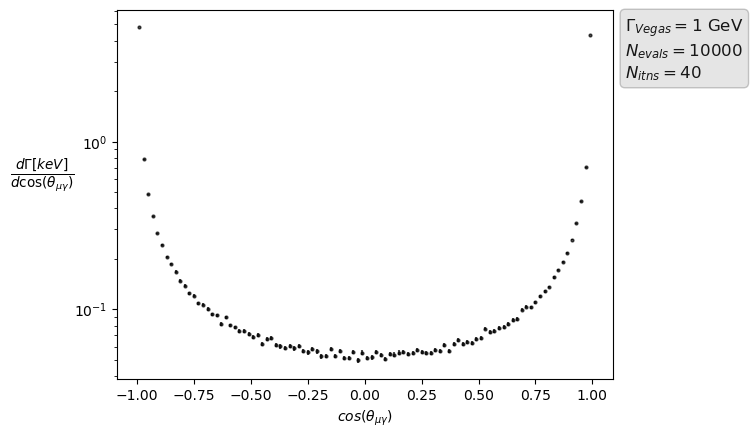

In [14]:
dI_cos = []
dI_cos_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos += [total_rate4['dI_4cos'][i].mean + total_rate6_1['dI_6_1cos'][i].mean + total_rate6_2['dI_6_2cos'][i].mean + total_rate6_3['dI_6_3cos'][i].mean + total_rate6_4['dI_6_4cos'][i].mean+ total_rate8_5['dI_8_5cos'][i].mean + total_rate8_6['dI_8_6cos'][i].mean + total_rate8_7['dI_8_7cos'][i].mean + total_rate8_8['dI_8_8cos'][i].mean+ total_rate8_9['dI_8_9cos'][i].mean + total_rate8_10['dI_8_10cos'][i].mean]
    dI_cos_errs += [total_rate4['dI_4cos'][i].sdev + total_rate6_1['dI_6_1cos'][i].sdev + total_rate6_2['dI_6_2cos'][i].sdev + total_rate6_3['dI_6_3cos'][i].sdev + total_rate6_4['dI_6_4cos'][i].sdev+ total_rate8_5['dI_8_5cos'][i].sdev + total_rate8_6['dI_8_6cos'][i].sdev + total_rate8_7['dI_8_7cos'][i].sdev + total_rate8_8['dI_8_8cos'][i].sdev+ total_rate8_9['dI_8_9cos'][i].sdev + total_rate8_10['dI_8_10cos'][i].sdev]
    
#rick.dump([dI_cos,dI_cos_errs], open('I_cos_mas_sep1', 'wb'))
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

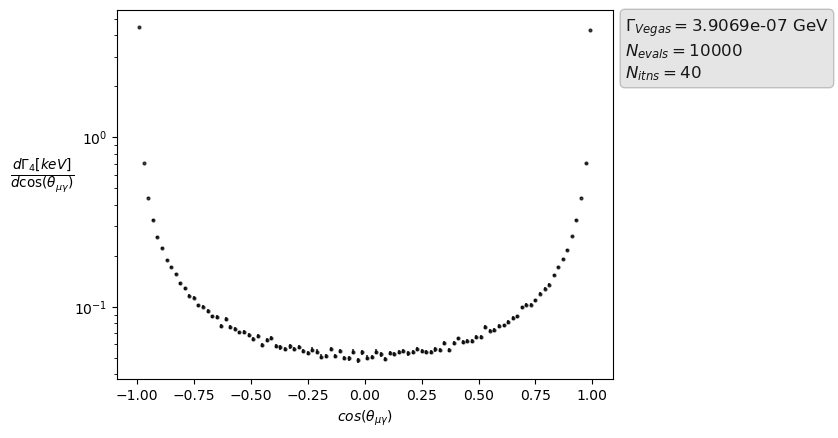

In [15]:
dI_cos4 = []
dI_cos4_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos4 += [total_rate4['dI_4cos'][i].mean]
    dI_cos4_errs += [total_rate4['dI_4cos'][i].sdev]
    
#rick.dump([dI_cos4,dI_cos4_errs], open('I_cos4_mas_sep1', 'wb'))
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos4) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos4_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_4, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

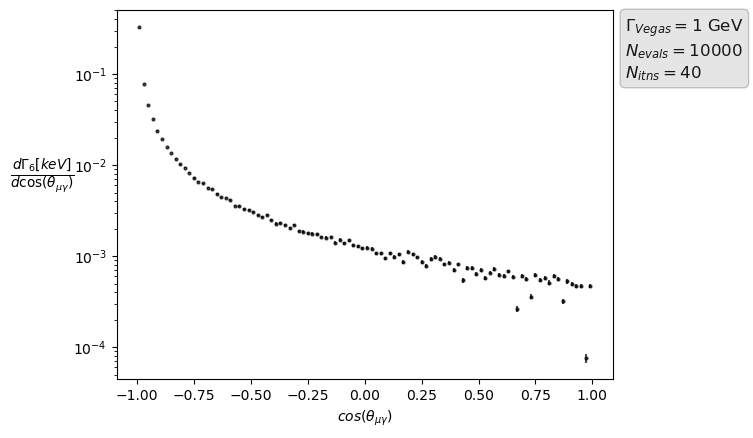

In [16]:
dI_cos6 = []
dI_cos6_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos6 += [total_rate6_1['dI_6_1cos'][i].mean + total_rate6_2['dI_6_2cos'][i].mean + total_rate6_3['dI_6_3cos'][i].mean + total_rate6_4['dI_6_4cos'][i].mean]
    dI_cos6_errs += [total_rate6_1['dI_6_1cos'][i].sdev + total_rate6_2['dI_6_2cos'][i].sdev + total_rate6_3['dI_6_3cos'][i].sdev + total_rate6_4['dI_6_4cos'][i].sdev]
    
#rick.dump([dI_cos6,dI_cos6_errs], open('I_cos6_mas_sep1', 'wb'))
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos6) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos6_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
#plt.ylim(-2.5 * 10**-6, 2 * 10**-5)
plt.ylabel(r'$\frac{d\Gamma_{6}[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

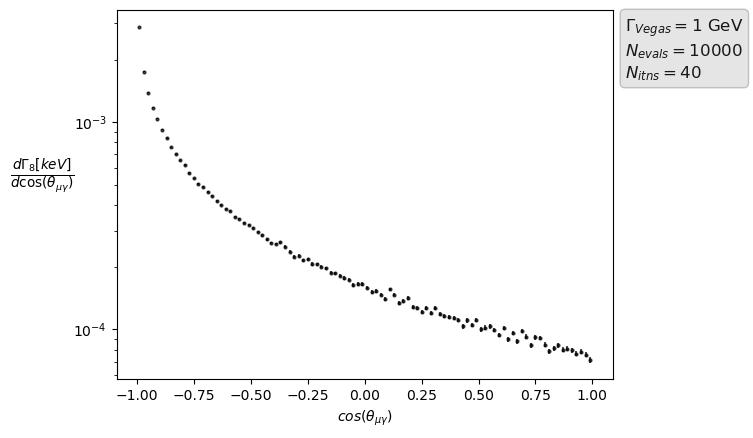

In [17]:
dI_cos8 = []
dI_cos8_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos8 += [total_rate8_5['dI_8_5cos'][i].mean + total_rate8_6['dI_8_6cos'][i].mean + total_rate8_7['dI_8_7cos'][i].mean + total_rate8_8['dI_8_8cos'][i].mean+ total_rate8_9['dI_8_9cos'][i].mean + total_rate8_10['dI_8_10cos'][i].mean]
    dI_cos8_errs += [total_rate8_5['dI_8_5cos'][i].sdev + total_rate8_6['dI_8_6cos'][i].sdev + total_rate8_7['dI_8_7cos'][i].sdev + total_rate8_8['dI_8_8cos'][i].sdev+ total_rate8_9['dI_8_9cos'][i].sdev + total_rate8_10['dI_8_10cos'][i].sdev]
    
#rick.dump([dI_cos8,dI_cos8_errs], open('I_cos8_mas2', 'wb'))
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos8) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos8_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{8}[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

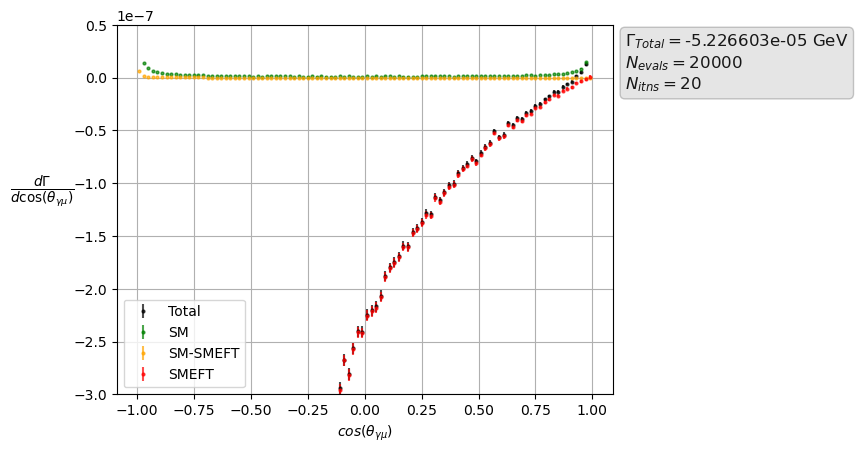

In [9]:
fig, ax = plt.subplots()

ax.errorbar(cos_s, np.array(dI_cos4)+np.array(dI_cos6)+np.array(dI_cos8), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_cos4_errs)+np.array(dI_cos6_errs)+np.array(dI_cos8_errs))
ax.errorbar(cos_s, np.array(dI_cos4), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_cos4_errs))
ax.errorbar(cos_s, np.array(dI_cos6), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_cos6_errs))
ax.errorbar(cos_s, np.array(dI_cos8), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_cos8_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(computed_4+computed_6+computed_8, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\cos(\theta_{\gamma\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\gamma\mu})$')
plt.ylim(-3 * 10**-7, 5 * 10**-8)
plt.legend()
#plt.xlim(0, 130)
plt.show()

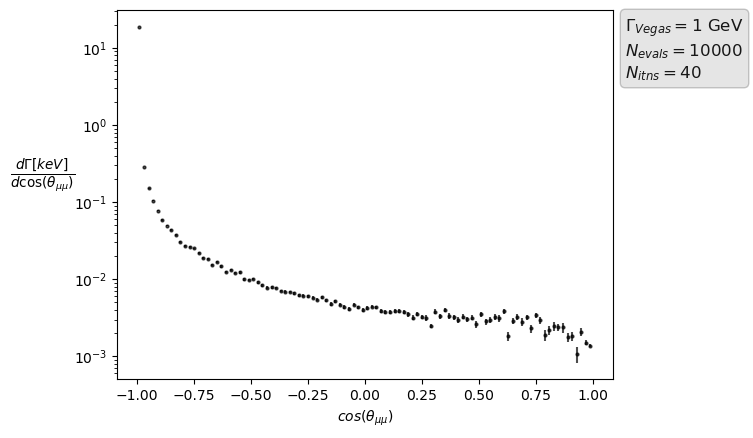

In [18]:
dI_cos_alt = []
dI_cos_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos_alt += [total_rate4['dI_4cos_alt'][i].mean + total_rate6_1['dI_6_1cos_alt'][i].mean + total_rate6_2['dI_6_2cos_alt'][i].mean + total_rate6_3['dI_6_3cos_alt'][i].mean + total_rate6_4['dI_6_4cos_alt'][i].mean+ total_rate8_5['dI_8_5cos_alt'][i].mean + total_rate8_6['dI_8_6cos_alt'][i].mean + total_rate8_7['dI_8_7cos_alt'][i].mean + total_rate8_8['dI_8_8cos_alt'][i].mean+ total_rate8_9['dI_8_9cos_alt'][i].mean + total_rate8_10['dI_8_10cos_alt'][i].mean]
    dI_cos_alt_errs += [total_rate4['dI_4cos_alt'][i].sdev + total_rate6_1['dI_6_1cos_alt'][i].sdev + total_rate6_2['dI_6_2cos_alt'][i].sdev + total_rate6_3['dI_6_3cos_alt'][i].sdev + total_rate6_4['dI_6_4cos_alt'][i].sdev+ total_rate8_5['dI_8_5cos_alt'][i].sdev + total_rate8_6['dI_8_6cos_alt'][i].sdev + total_rate8_7['dI_8_7cos_alt'][i].sdev + total_rate8_8['dI_8_8cos_alt'][i].sdev+ total_rate8_9['dI_8_9cos_alt'][i].sdev + total_rate8_10['dI_8_10cos_alt'][i].sdev]
    
#rick.dump([dI_cos_alt,dI_cos_alt_errs], open('I_cos_alt_mas1', 'wb'))

norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

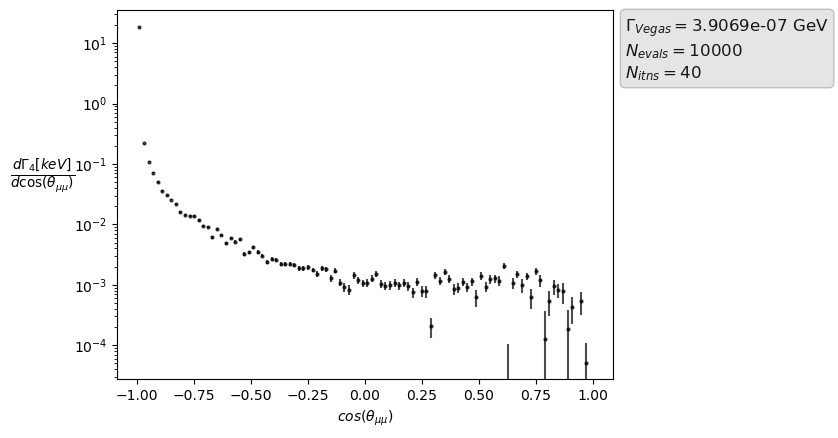

In [19]:
dI_cos4_alt = []
dI_cos4_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos4_alt += [total_rate4['dI_4cos_alt'][i].mean]
    dI_cos4_alt_errs += [total_rate4['dI_4cos_alt'][i].sdev]
    
#rick.dump([dI_cos4_alt,dI_cos4_alt_errs], open('I_4cos_alt_mas2', 'wb'))

norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos4_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos4_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_4, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

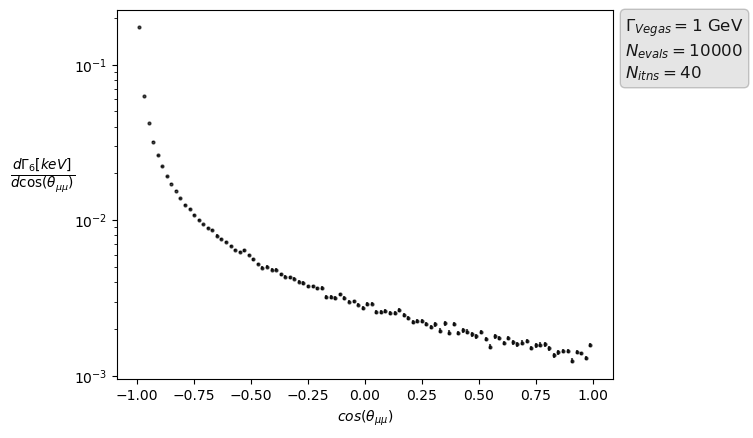

In [20]:
dI_cos6_alt = []
dI_cos6_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos6_alt += [total_rate6_1['dI_6_1cos_alt'][i].mean + total_rate6_2['dI_6_2cos_alt'][i].mean + total_rate6_3['dI_6_3cos_alt'][i].mean + total_rate6_4['dI_6_4cos_alt'][i].mean]
    dI_cos6_alt_errs += [total_rate6_1['dI_6_1cos_alt'][i].sdev + total_rate6_2['dI_6_2cos_alt'][i].sdev + total_rate6_3['dI_6_3cos_alt'][i].sdev + total_rate6_4['dI_6_4cos_alt'][i].sdev]
    
#rick.dump([dI_cos6_alt,dI_cos6_alt_errs], open('I_6cos_alt_mas2', 'wb'))

norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos6_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos6_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
#plt.ylim(-2.5 * 10**-6, 2 * 10**-5)
plt.ylabel(r'$\frac{d\Gamma_{6}[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

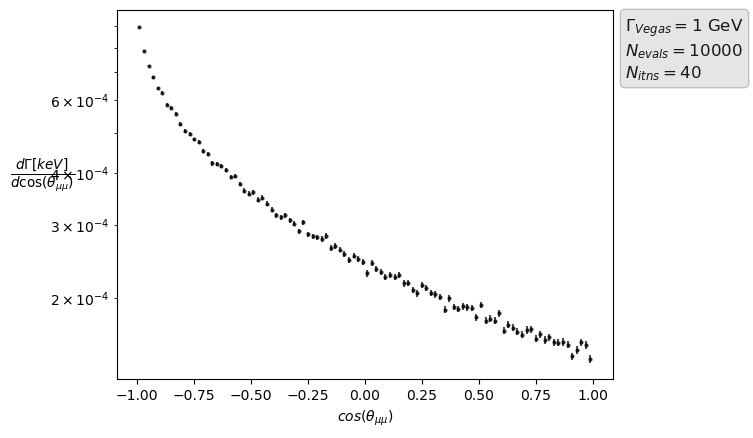

In [21]:
dI_cos8_alt = []
dI_cos8_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos8_alt += [total_rate8_5['dI_8_5cos_alt'][i].mean + total_rate8_6['dI_8_6cos_alt'][i].mean + total_rate8_7['dI_8_7cos_alt'][i].mean + total_rate8_8['dI_8_8cos_alt'][i].mean+ total_rate8_9['dI_8_9cos_alt'][i].mean + total_rate8_10['dI_8_10cos_alt'][i].mean]
    dI_cos8_alt_errs += [total_rate8_5['dI_8_5cos_alt'][i].sdev + total_rate8_6['dI_8_6cos_alt'][i].sdev + total_rate8_7['dI_8_7cos_alt'][i].sdev + total_rate8_8['dI_8_8cos_alt'][i].sdev+ total_rate8_9['dI_8_9cos_alt'][i].sdev + total_rate8_10['dI_8_10cos_alt'][i].sdev]
    
#rick.dump([dI_cos8_alt,dI_cos8_alt_errs], open('I_8cos_altmas2', 'wb'))

norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos8_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos8_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

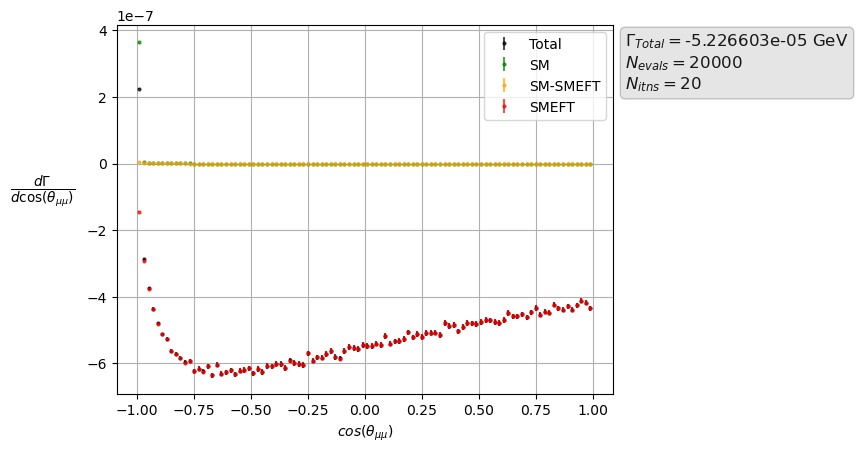

In [13]:
fig, ax = plt.subplots()

ax.errorbar(cos_s, np.array(dI_cos4_alt)+np.array(dI_cos6_alt)+np.array(dI_cos8_alt), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_cos4_alt_errs)+np.array(dI_cos6_alt_errs)+np.array(dI_cos8_alt_errs))
ax.errorbar(cos_s, np.array(dI_cos4_alt), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_cos4_alt_errs))
ax.errorbar(cos_s, np.array(dI_cos6_alt), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_cos6_alt_errs))
ax.errorbar(cos_s, np.array(dI_cos8_alt), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_cos8_alt_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(computed_4+computed_6+computed_8, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
#plt.ylim(-1 * 10**-8, 0.5 * 10**-8)
plt.legend()
#plt.xlim(0, 130)
plt.show()

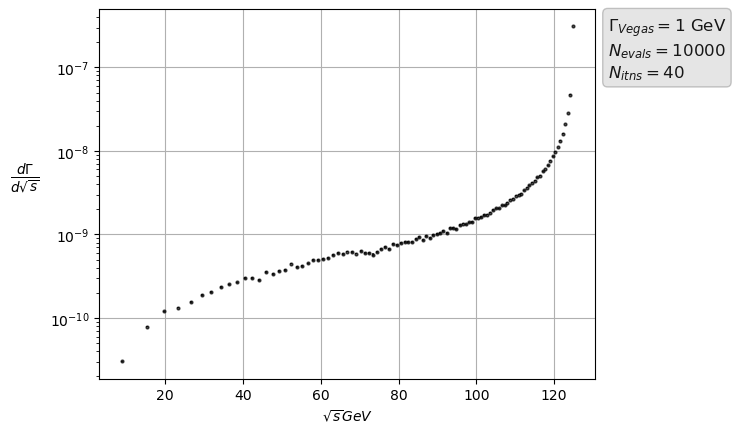

In [22]:
dIs = []
dI_errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dIs += [(total_rate4['dI_4'][i].mean + total_rate6_1['dI_6_1'][i].mean + total_rate6_2['dI_6_2'][i].mean + total_rate6_3['dI_6_3'][i].mean + total_rate6_4['dI_6_4'][i].mean+ total_rate8_5['dI_8_5'][i].mean + total_rate8_6['dI_8_6'][i].mean + total_rate8_7['dI_8_7'][i].mean + total_rate8_8['dI_8_8'][i].mean+ total_rate8_9['dI_8_9'][i].mean + total_rate8_10['dI_8_10'][i].mean) / sdbins[i]]
    dI_errs += [(total_rate4['dI_4'][i].sdev + total_rate6_1['dI_6_1'][i].sdev + total_rate6_2['dI_6_2'][i].sdev + total_rate6_3['dI_6_3'][i].sdev + total_rate6_4['dI_6_4'][i].sdev+ total_rate8_5['dI_8_5'][i].sdev + total_rate8_6['dI_8_6'][i].sdev + total_rate8_7['dI_8_7'][i].sdev + total_rate8_8['dI_8_8'][i].sdev+ total_rate8_9['dI_8_9'][i].sdev + total_rate8_10['dI_8_10'][i].sdev) / sdbins[i]]
    
#rick.dump([dIs,dI_errs], open('I_mas1', 'wb'))

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dIs), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

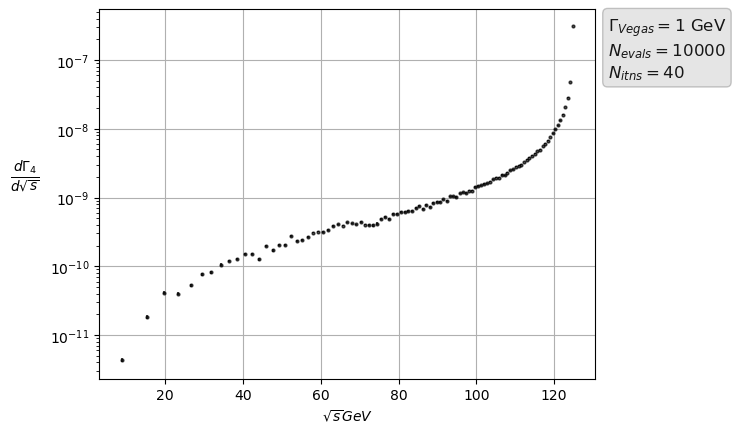

In [23]:
dI_4s = []
dI_4errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_4s += [(total_rate4['dI_4'][i].mean) / sdbins[i]]
    dI_4errs += [(total_rate4['dI_4'][i].sdev) / sdbins[i]]

    
#rick.dump([dI_4s,dI_4errs], open('I_4_mas2', 'wb'))

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_4s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_4errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{4}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

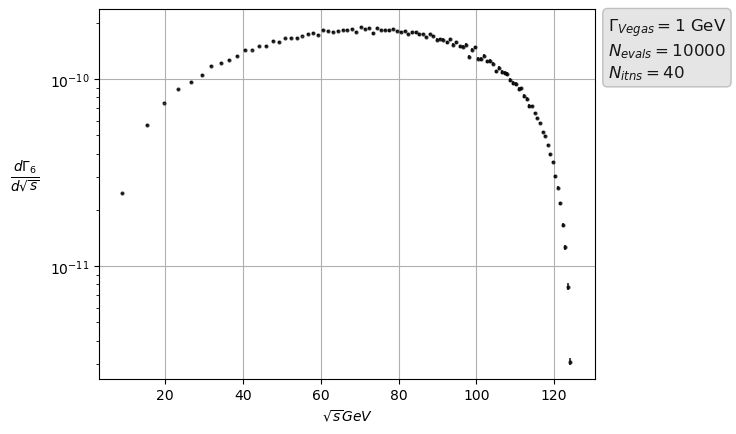

In [24]:
dI_6s = []
dI_6errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_6s += [(total_rate6_1['dI_6_1'][i].mean + total_rate6_2['dI_6_2'][i].mean + total_rate6_3['dI_6_3'][i].mean + total_rate6_4['dI_6_4'][i].mean) / sdbins[i]]
    dI_6errs += [(total_rate6_1['dI_6_1'][i].sdev + total_rate6_2['dI_6_2'][i].sdev + total_rate6_3['dI_6_3'][i].sdev + total_rate6_4['dI_6_4'][i].sdev) / sdbins[i]]


#rick.dump([dI_6s,dI_6errs], open('I_6_mas2', 'wb'))    

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_6s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_6errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{6}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(-10**-14, 5 * 10**-13)
#plt.xlim(0, 130)
plt.show()

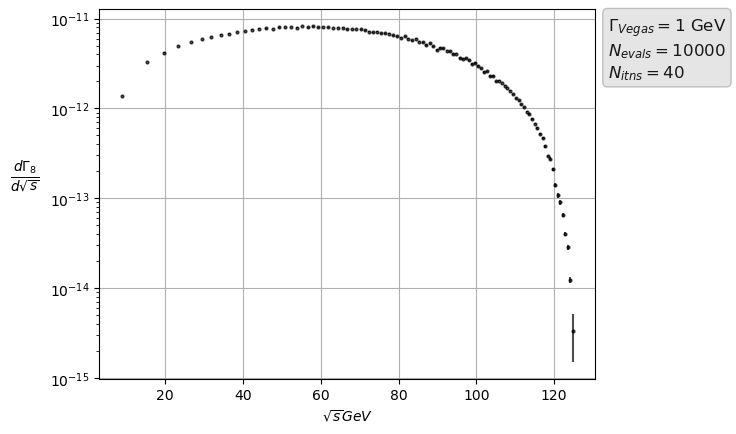

In [25]:
dI_8s = []
dI_8errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8s += [(total_rate8_5['dI_8_5'][i].mean + total_rate8_6['dI_8_6'][i].mean + total_rate8_7['dI_8_7'][i].mean + total_rate8_8['dI_8_8'][i].mean+ total_rate8_9['dI_8_9'][i].mean + total_rate8_10['dI_8_10'][i].mean) / sdbins[i]]
    dI_8errs += [(total_rate8_5['dI_8_5'][i].sdev + total_rate8_6['dI_8_6'][i].sdev + total_rate8_7['dI_8_7'][i].sdev + total_rate8_8['dI_8_8'][i].sdev+ total_rate8_9['dI_8_9'][i].sdev + total_rate8_10['dI_8_10'][i].sdev) / sdbins[i]]


#rick.dump([dI_8s,dI_8errs], open('I_8_mas2', 'wb'))    

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_8s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

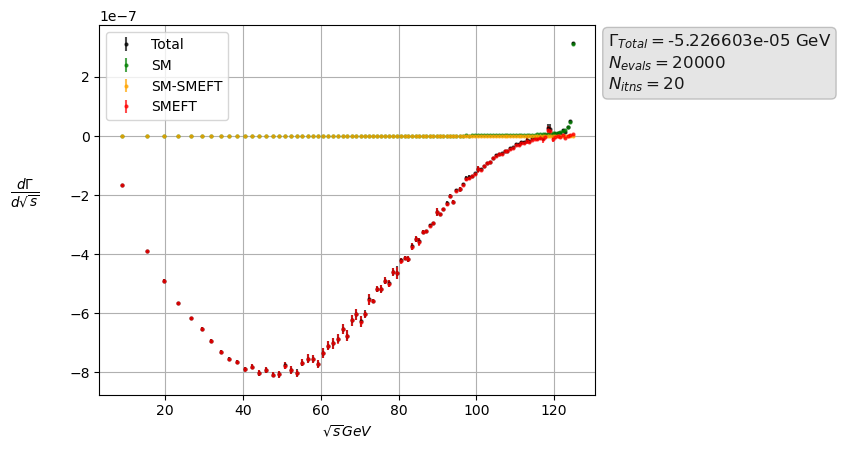

In [17]:
fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_4s)+np.array(dI_6s)+np.array(dI_8s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_4errs)+np.array(dI_6errs)+np.array(dI_8errs))
ax.errorbar(sqs, np.array(dI_4s), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_4errs))
ax.errorbar(sqs, np.array(dI_6s), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_6errs))
ax.errorbar(sqs, np.array(dI_8s), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_8errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(computed_4+computed_6+computed_8, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(-1.4 * 10**-8, 2.5 * 10**-8)
plt.legend()
#plt.xlim(0, 130)
plt.show()

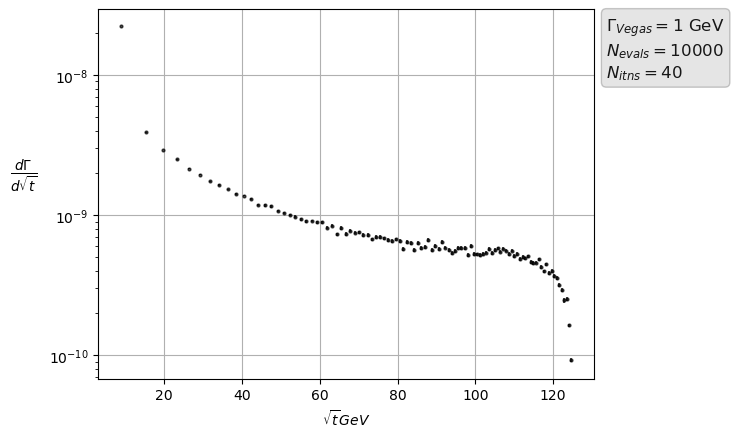

In [26]:
dI_ts = []
dI_terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_ts += [(total_rate4['dI_4_t'][i].mean + total_rate6_1['dI_6_1t'][i].mean + total_rate6_2['dI_6_2t'][i].mean + total_rate6_3['dI_6_3t'][i].mean + total_rate6_4['dI_6_4t'][i].mean+ total_rate8_5['dI_8_5t'][i].mean + total_rate8_6['dI_8_6t'][i].mean + total_rate8_7['dI_8_7t'][i].mean + total_rate8_8['dI_8_8t'][i].mean+ total_rate8_9['dI_8_9t'][i].mean + total_rate8_10['dI_8_10t'][i].mean) / sdbins[i]]
    dI_terrs += [(total_rate4['dI_4_t'][i].sdev + total_rate6_1['dI_6_1t'][i].sdev + total_rate6_2['dI_6_2t'][i].sdev + total_rate6_3['dI_6_3t'][i].sdev + total_rate6_4['dI_6_4t'][i].sdev+ total_rate8_5['dI_8_5t'][i].sdev + total_rate8_6['dI_8_6t'][i].sdev + total_rate8_7['dI_8_7t'][i].sdev + total_rate8_8['dI_8_8t'][i].sdev+ total_rate8_9['dI_8_9t'][i].sdev + total_rate8_10['dI_8_10t'][i].sdev) / sdbins[i]]

    
#rick.dump([dI_ts,dI_terrs], open('I_t_mas1', 'wb'))

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

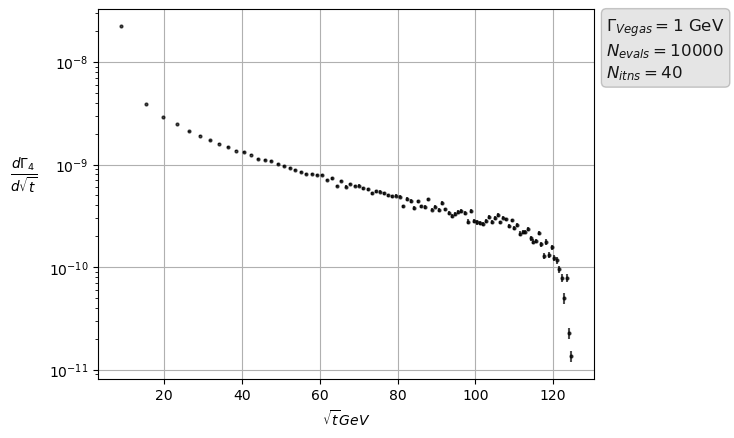

In [27]:
dI_4ts = []
dI_4terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_4ts += [(total_rate4['dI_4_t'][i].mean) / sdbins[i]]
    dI_4terrs += [(total_rate4['dI_4_t'][i].sdev) / sdbins[i]]

    
#rick.dump([dI_4ts,dI_4terrs], open('I_4t_mas2', 'wb'))

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_4ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_4terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

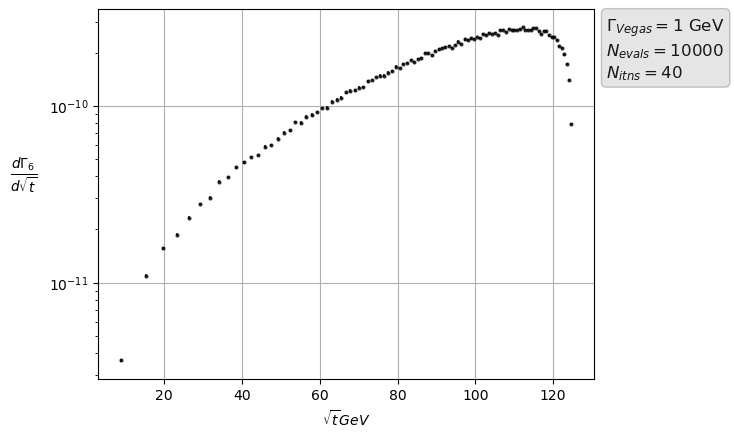

In [28]:
dI_6ts = []
dI_6terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_6ts += [(total_rate6_1['dI_6_1t'][i].mean + total_rate6_2['dI_6_2t'][i].mean + total_rate6_3['dI_6_3t'][i].mean + total_rate6_4['dI_6_4t'][i].mean) / sdbins[i]]
    dI_6terrs += [(total_rate6_1['dI_6_1t'][i].sdev + total_rate6_2['dI_6_2t'][i].sdev + total_rate6_3['dI_6_3t'][i].sdev + total_rate6_4['dI_6_4t'][i].sdev) / sdbins[i]]

    
#rick.dump([dI_6ts,dI_6terrs], open('I_6t_mas2', 'wb'))

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_6ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_6terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{6}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

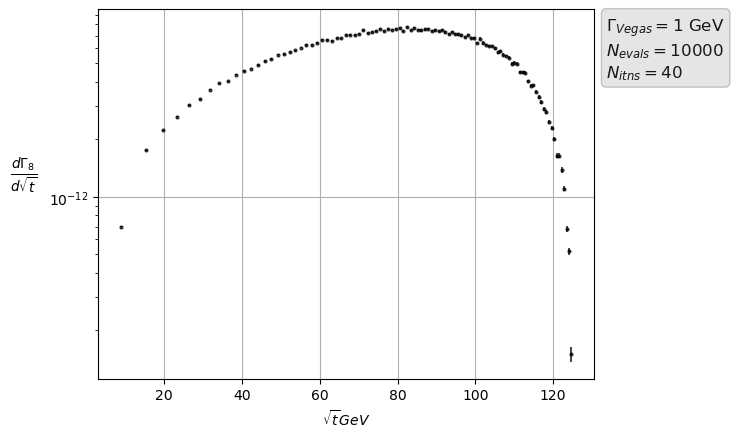

In [29]:
dI_8ts = []
dI_8terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8ts += [(total_rate8_5['dI_8_5t'][i].mean + total_rate8_6['dI_8_6t'][i].mean + total_rate8_7['dI_8_7t'][i].mean + total_rate8_8['dI_8_8t'][i].mean+ total_rate8_9['dI_8_9t'][i].mean + total_rate8_10['dI_8_10t'][i].mean) / sdbins[i]]
    dI_8terrs += [(total_rate8_5['dI_8_5t'][i].sdev + total_rate8_6['dI_8_6t'][i].sdev + total_rate8_7['dI_8_7t'][i].sdev + total_rate8_8['dI_8_8t'][i].sdev+ total_rate8_9['dI_8_9t'][i].sdev + total_rate8_10['dI_8_10t'][i].sdev) / sdbins[i]]

    
#rick.dump([dI_8ts,dI_8terrs], open('I_8t_mas2', 'wb'))

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_8ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

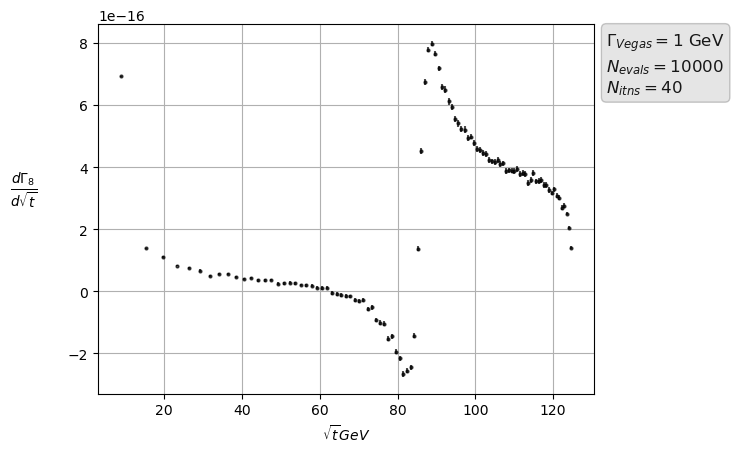

In [37]:
dI_8ts = []
dI_8terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8ts += [(total_rate6_2['dI_6_2t'][i].mean) / sdbins[i]]
    dI_8terrs += [(total_rate6_2['dI_6_2t'][i].sdev) / sdbins[i]]

    
#rick.dump([dI_8ts,dI_8terrs], open('I_8t_mas2', 'wb'))

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_8ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

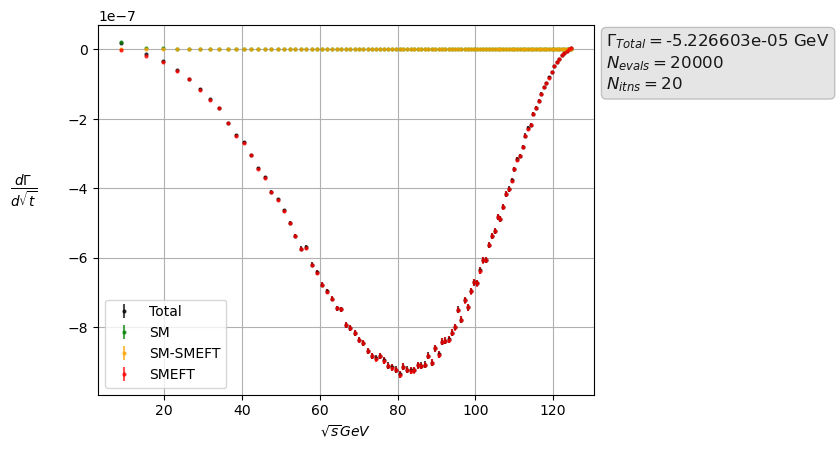

In [21]:
fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_4ts)+np.array(dI_6ts)+np.array(dI_8ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_4terrs)+np.array(dI_6terrs)+np.array(dI_8terrs))
ax.errorbar(sqt, np.array(dI_4ts), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_4terrs))
ax.errorbar(sqt, np.array(dI_6ts), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_6terrs))
ax.errorbar(sqt, np.array(dI_8ts), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_8terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(computed_4+computed_6+computed_8, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(-1.6 * 10**-8, 1 * 10**-8)
plt.legend()
#plt.xlim(0, 130)
plt.show()